# Lesson: Natural Language Processing - EXPLORATION

<a href = "https://www.canva.com/design/DAFmeYEK1zQ/Fqr6k9NfwToipJqyFmeXXg/view?utm_content=DAFmeYEK1zQ&utm_campaign=designshare&utm_medium=link&utm_source=publishsharelink">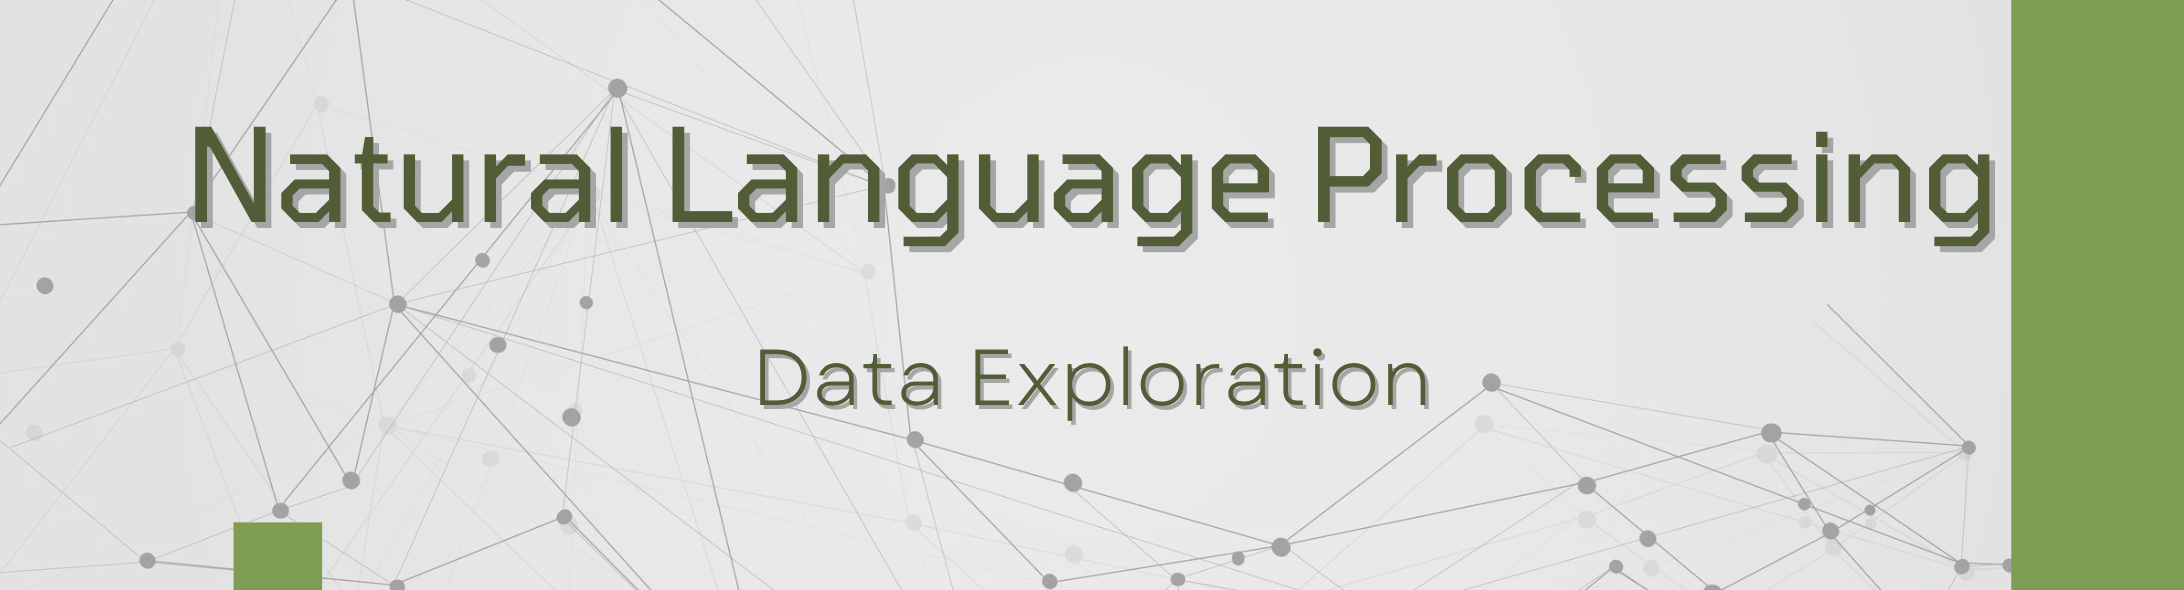
</a>

<hr style="border:2px solid gray">

# NLP EDA

Basically, exploration and modeling boil down to a single question:

How do we quantify our data/text

In this lesson, we'll explore answers to this question that will aid in visualization.

- word frequency (by label)
- ngrams
- word cloud
- sentiment analysis
- other common features

## Setup

Data is spam/ham text messages.

<a href = "https://pypi.org/project/wordcloud/">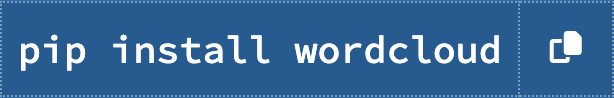</a>

In [1]:
#Imports
import re

import unicodedata
import nltk
from wordcloud import WordCloud

import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from env import get_connection

In [3]:
#Get SQL database url
url = get_connection('spam_db')

In [4]:
#Define SQL query
query = '''
        SELECT *
        FROM spam
        '''

In [5]:
#Read SQL
df = pd.read_sql(query, url, index_col='id')
df.head()

,label,text
id,,
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [6]:
#Value counts of labels
df['label'].value_counts()

ham     4825
spam     747
Name: label, dtype: int64

### If we look at this in the context of a classification problem,
we may ask:
 - What leads to a spam text?
 - What leads to a ham text?
 

In [7]:
df.iloc[1].text

'Ok lar... Joking wif u oni...'

In [8]:
# recall how the string method join operates -- glues together 
# all instances inside of a iterable using whatever is specified
# ahead of the method call:
# english: glue these words together with a empty space

' '.join(['this', 'is', 'a', 'list', 'of', 'strings'])

'this is a list of strings'

In [9]:
ADDITIONAL_STOPWORDS = ['r', 'u', '2', '4', 'ltgt']

def clean(text):
    '''
    A simple function to cleanup text data.
    
    Args:
        text (str): The text to be cleaned.
        
    Returns:
        list: A list of lemmatized words after cleaning.
    '''
    
    # basic_clean() function from last lesson:
    # Normalize text by removing diacritics, encoding to ASCII, decoding to UTF-8, and converting to lowercase
    text = (unicodedata.normalize('NFKD', text)
             .encode('ascii', 'ignore')
             .decode('utf-8', 'ignore')
             .lower())
    
    # Remove punctuation, split text into words
    words = re.sub(r'[^\w\s]', '', text).split()
    
    
    # lemmatize() function from last lesson:
    # Initialize WordNet lemmatizer
    wnl = nltk.stem.WordNetLemmatizer()
    
    # Combine standard English stopwords with additional stopwords
    stopwords = nltk.corpus.stopwords.words('english') + ADDITIONAL_STOPWORDS
    
    # Lemmatize words and remove stopwords
    cleaned_words = [wnl.lemmatize(word) for word in words if word not in stopwords]
    
    return cleaned_words

In [10]:
# we can do that process with a join on a Series and not just a list
# we will do that for ham words, spam words, and all words
# we will pass our basic cleaning on top of that

ham_words = clean(' '.join(df[df.label=="ham"]['text']))
spam_words = clean(' '.join(df[df.label=="spam"]['text']))
all_words = clean(' '.join(df['text']))

In [11]:
len(all_words), len(spam_words), len(ham_words)

(50018, 12044, 37974)

In [12]:
#ham_words

In [13]:
# let's get some sights on word frequency by taking our words back apart
# we will split each set of words by the spaces,
# turn that into a list, cast that list as a Series,
# and then take the value counts of that Series
# We will do this for each type of word present

ham_freq = pd.Series(ham_words).value_counts()
spam_freq = pd.Series(spam_words).value_counts()
all_freq = pd.Series(all_words).value_counts()

In [14]:
spam_freq.head()

call    359
free    216
txt     150
ur      144
text    137
dtype: int64

In [15]:
ham_freq.head()

im      449
get     314
go      273
ok      272
dont    257
dtype: int64

## Exploration

Represent text as word frequencies.
- concat all frequencies together into a dataframe

In [16]:
ham_freq

im            449
get           314
go            273
ok            272
dont          257
             ... 
gained          1
surrounded      1
pressure        1
cage            1
bitching        1
Length: 6981, dtype: int64

In [17]:
pd.concat([ham_freq, spam_freq, all_freq], axis=1).fillna(0).astype(int)

,0,1,2
im,449,13,462
get,314,83,397
go,273,31,304
ok,272,5,277
dont,257,22,279
...,...,...,...
resub,0,1,1
expired,0,1,1
9153,0,1,1
okmail,0,1,1


In [18]:
# lets combine all 3 dfs horizontally
# fill any missing values with zero
# convert the resulting df to contain only integer values:

word_counts = pd.concat([ham_freq, spam_freq, all_freq], axis=1).fillna(0).astype(int)

# rename the col names
word_counts.columns = ['ham', 'spam', 'all']

word_counts.head()

,ham,spam,all
im,449,13,462
get,314,83,397
go,273,31,304
ok,272,5,277
dont,257,22,279


In [19]:
word_counts.sample(5).head()

,ham,spam,all
sara,0,1,1
usb,2,0,2
phone,82,57,139
travel,3,2,5
09066649731from,0,1,1


- What are the most frequently occuring words?
- Are there any words that uniquely identify a spam or ham message? 
    - (*I.e. words present in one type of message but not the other?*)

In [20]:
# sort by 'all'

word_counts.sort_values('all', ascending=False)

,ham,spam,all
call,241,359,600
im,449,13,462
get,314,83,397
ur,240,144,384
go,273,31,304
...,...,...,...
edition,1,0,1
algorithm,1,0,1
textbook,1,0,1
3230,1,0,1


In [21]:
# sort by 'ham' and 'spam' columns

word_counts.sort_values(['ham', 'spam', 'all'], ascending=False)

,ham,spam,all
im,449,13,462
get,314,83,397
go,273,31,304
ok,272,5,277
dont,257,22,279
...,...,...,...
resub,0,1,1
expired,0,1,1
9153,0,1,1
okmail,0,1,1


### Visualization

- ham vs spam count for 20 most common words
- ham vs spam proportion for 20 most common words

In [22]:
# setting basic style parameters for matplotlib
plt.rc('figure', figsize=(13, 7))
plt.style.use('seaborn-darkgrid')

/var/folders/xv/ltdj6hd169j2bd0gclmjj3th0000gn/T/ipykernel_23515/2462859176.py:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


<Axes: >

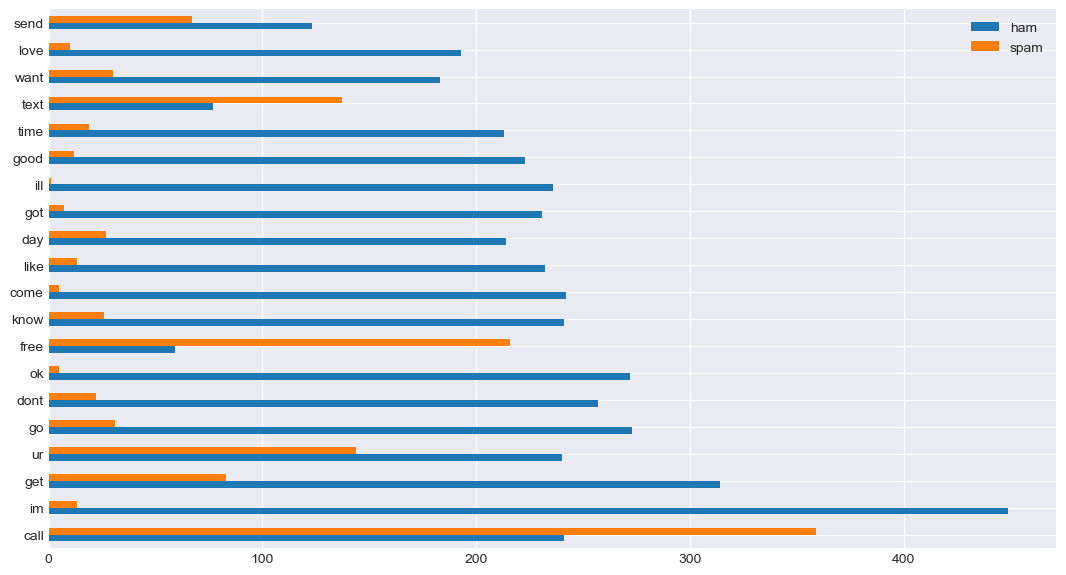

In [23]:
word_counts.sort_values('all', ascending=False)[['ham', 'spam']].head(20).plot.barh()

In [24]:
word_counts.sort_values('all', ascending=False).head(20)\
.apply(lambda row: row/row['all'], axis=1)

,ham,spam,all
call,0.401667,0.598333,1.0
im,0.971861,0.028139,1.0
get,0.790932,0.209068,1.0
ur,0.625000,0.375000,1.0
go,0.898026,0.101974,1.0
dont,0.921147,0.078853,1.0
ok,0.981949,0.018051,1.0
free,0.214545,0.785455,1.0
know,0.902622,0.097378,1.0
come,0.979757,0.020243,1.0


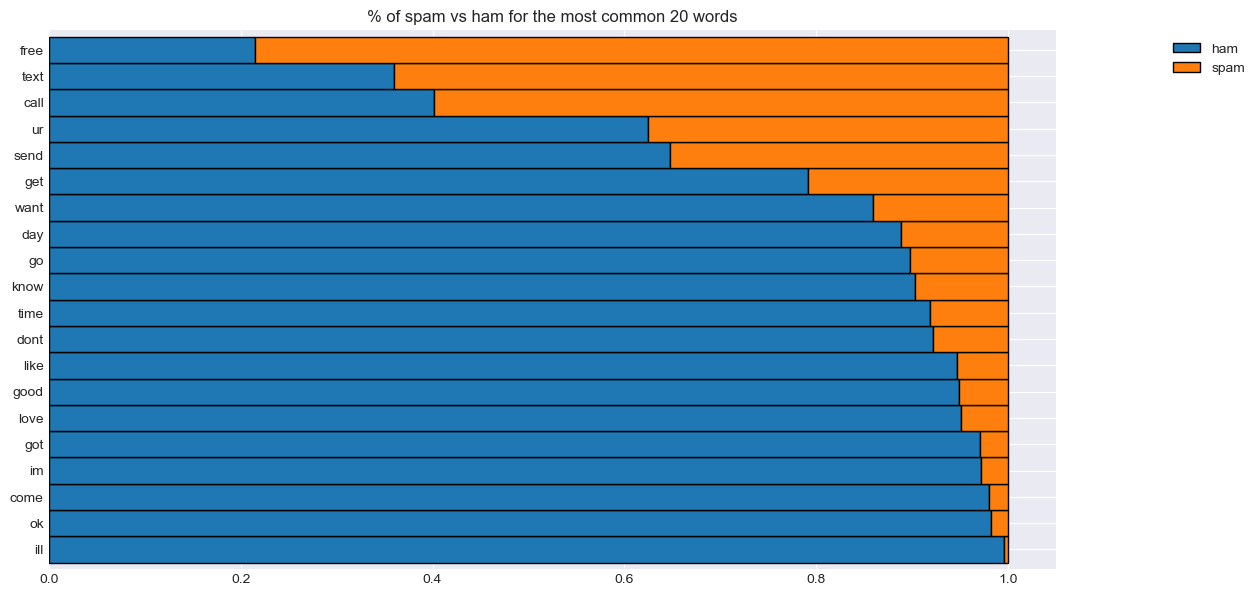

In [25]:
(word_counts.sort_values('all', ascending=False)
.head(20)
.apply(lambda row: row/row['all'], axis=1)
.drop(columns='all')
.sort_values(by='spam')
.plot.barh(stacked=True, width=1, ec='black')
)


plt.title('% of spam vs ham for the most common 20 words')
plt.legend(bbox_to_anchor=(1.2, 1.0),loc='upper right')
plt.show()

## n-grams

**bigram**: combinations of 2 words

Represent text as combinations of 2 words

In [26]:
sentence = 'Today is Monday ! ! ! and the weather is ok .'

In [27]:
list(nltk.bigrams(sentence.split()))

[('Today', 'is'),
 ('is', 'Monday'),
 ('Monday', '!'),
 ('!', '!'),
 ('!', '!'),
 ('!', 'and'),
 ('and', 'the'),
 ('the', 'weather'),
 ('weather', 'is'),
 ('is', 'ok'),
 ('ok', '.')]

**Be Careful!** Make sure you are making bigrams out of *words*.

- what are the most common bigrams? 
    - spam bigrams? 
    - ham bigrams?
    
- visualize 20 most common bigrams, most common ham bigrams
- ngrams

Find the most common bigram and then find a representative text

In [28]:
list(nltk.ngrams(sentence.split(), 3))

[('Today', 'is', 'Monday'),
 ('is', 'Monday', '!'),
 ('Monday', '!', '!'),
 ('!', '!', '!'),
 ('!', '!', 'and'),
 ('!', 'and', 'the'),
 ('and', 'the', 'weather'),
 ('the', 'weather', 'is'),
 ('weather', 'is', 'ok'),
 ('is', 'ok', '.')]

<Axes: >

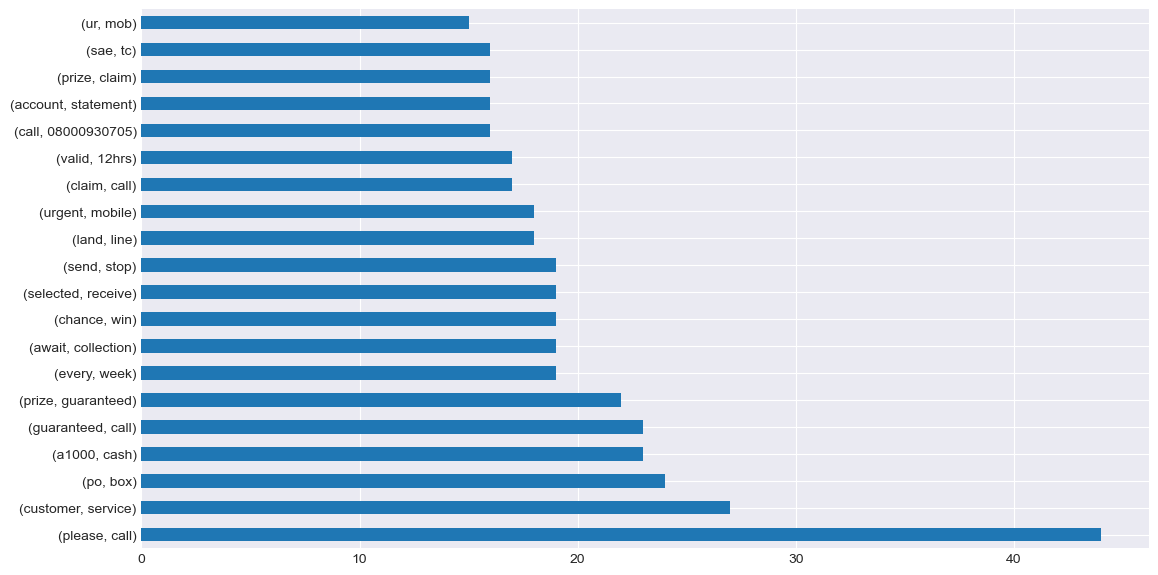

In [29]:
pd.Series(nltk.bigrams(spam_words)).value_counts().head(20).plot.barh()

# <a href = "https://amueller.github.io/word_cloud/"> Word Cloud</a>
**Making a word cloud:**
1. call `WordCloud.generate` 
1. reference a string with all words, not a list or series
1. call `plt.imshow` on the generation from wordcloud

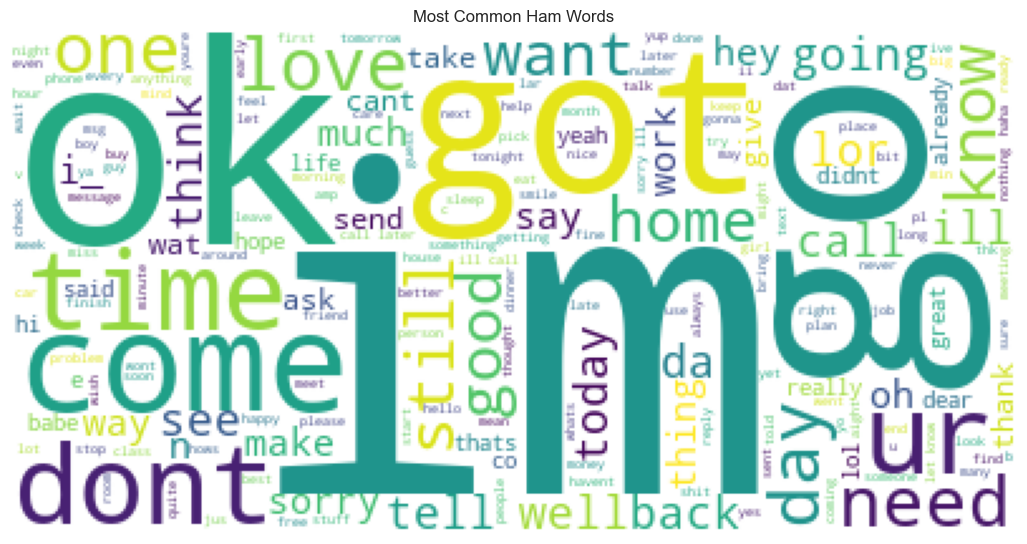

In [31]:
img = WordCloud(background_color='white').generate(' '.join(ham_words))

plt.imshow(img)
plt.axis('off')
plt.title('Most Common Ham Words')
plt.show()

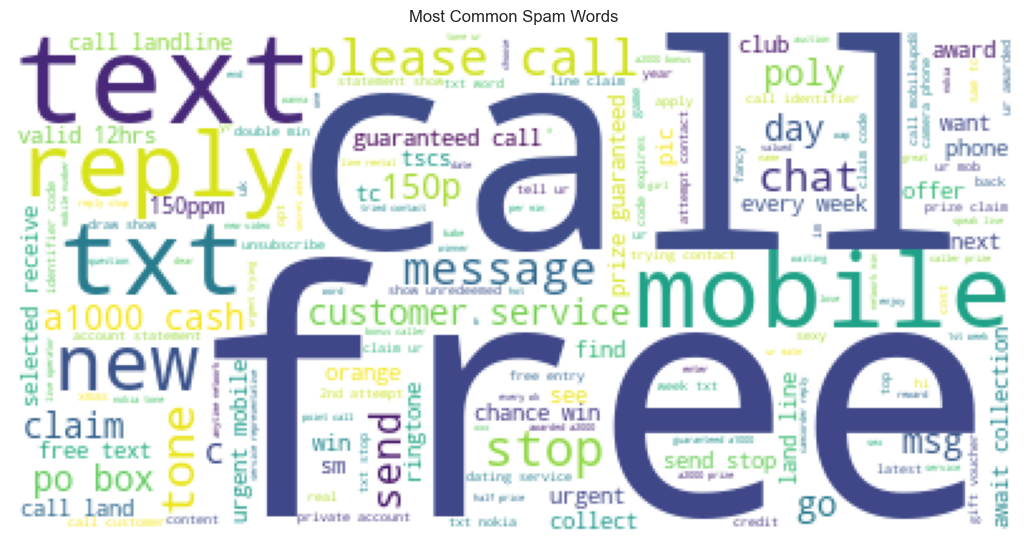

In [32]:
img = WordCloud(background_color='white').generate(' '.join(spam_words))

plt.imshow(img)
plt.axis('off')
plt.title('Most Common Spam Words')
plt.show()

## Other Common Features

Any NLP dataset will have domain specific features, for example: number of retweets, number of @mentions, number of upvotes, or mean time to respond to a support chat. In addition to these domain specific features, some common measures for a document are:

- character count
- word count
- sentence count
- stopword count
- unique word count
- punctuation count
- average word length
- average words per sentence
- word to stopword ratio

Create one or more of the above features and visualize it.

In [33]:
# add two new columns 'message_length' and 'word_count'

df['message_length'] = df['text'].str.len()

In [34]:
# we apply our clean function, apply len chained on it
# if we did not want to clean this before word count, we would want to do a split on it

df['word_count'] = df.text.apply(clean).apply(len)

In [35]:
df.head()

,label,text,message_length,word_count
id,,,,
0,ham,"Go until jurong point, crazy.. Available only ...",111,16
1,ham,Ok lar... Joking wif u oni...,29,5
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,22
3,ham,U dun say so early hor... U c already then say...,49,7
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,8


## Sentiment

A number indicating whether the document is positive or negative.

- knowledge-based + statistical approach
- relies on human-labelled data
    - combination of qualitative and quantitative methods
    - then empirically validate
- different models for diff domains (e.g. social media vs news)
- for social media
    - Afinn ([github](https://github.com/fnielsen/afinn) + [whitepaper](http://www2.imm.dtu.dk/pubdb/edoc/imm6006.pdf))
    - Vader ([github](https://github.com/cjhutto/vaderSentiment) + [whitepaper](http://comp.social.gatech.edu/papers/icwsm14.vader.hutto.pdf)) `nltk.sentiment.vader.SentimentIntensityAnalyzer`. Pre-trained sentiment analyzer (**V**alence **A**ware **D**ictionary and s**E**ntiment **R**easoner).)


From your terminal:
`python -c 'import nltk;nltk.download("vader_lexicon")'`

In [37]:
import nltk.sentiment
# we call nltk.sentiment.SentimentIntensityAnalyser()
# use polarity_scores from that object

sia = nltk.sentiment.SentimentIntensityAnalyzer()

In [38]:
sia.polarity_scores('He is really good')

{'neg': 0.0, 'neu': 0.484, 'pos': 0.516, 'compound': 0.4927}

In [39]:
sia.polarity_scores('The food is good but service is slow')

{'neg': 0.0, 'neu': 0.782, 'pos': 0.218, 'compound': 0.2382}

In [40]:
sia.polarity_scores('I hate you')

{'neg': 0.787, 'neu': 0.213, 'pos': 0.0, 'compound': -0.5719}

In [41]:
sia.polarity_scores('I hate you :)')

{'neg': 0.481, 'neu': 0.13, 'pos': 0.39, 'compound': -0.1779}

In [42]:
sia.polarity_scores('I hate hate speech')

{'neg': 0.881, 'neu': 0.119, 'pos': 0.0, 'compound': -0.8126}

In [43]:
sia.polarity_scores('I hate hate speech (^_^)')

{'neg': 0.787, 'neu': 0.213, 'pos': 0.0, 'compound': -0.8126}

In [44]:
sia.polarity_scores('He is a bad, bad man')

{'neg': 0.7, 'neu': 0.3, 'pos': 0.0, 'compound': -0.7906}

In [45]:
sia.polarity_scores('bad bad bad bad bad bad bad hate most bad')

{'neg': 0.969, 'neu': 0.031, 'pos': 0.0, 'compound': -0.9858}

In [46]:
sia.polarity_scores('HATE, HATE, HATE, LOATHE ENTIRELY')

{'neg': 0.935, 'neu': 0.065, 'pos': 0.0, 'compound': -0.936}

In [47]:
sia.polarity_scores('death')

{'neg': 1.0, 'neu': 0.0, 'pos': 0.0, 'compound': -0.5994}

Things that can influence Sentiment Score:
1. Punctuations. Can increase the intensity
2. Capitalization. Can increase the intensity
3. Degree modifiers
4. Conjunctions

It can handle Emojis and slangs

___
Apply this to the text message data

In [48]:
# grab the sentiment from each of the texts as they stand:
# apply a lambda function on each cell in the text column:
# polarity_score's value associtated with the "compound"
# key for each score

df['sentiment'] = df['text'].apply(lambda doc: sia.polarity_scores(doc)['compound'])
df.head()

,label,text,message_length,word_count,sentiment
id,,,,,
0,ham,"Go until jurong point, crazy.. Available only ...",111,16,0.6249
1,ham,Ok lar... Joking wif u oni...,29,5,0.4767
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,22,0.7964
3,ham,U dun say so early hor... U c already then say...,49,7,0.0000
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,8,-0.1027


In [49]:
# is the mean and median values of sentiment score different for ham vs spam?

df.groupby('label').sentiment.agg(['mean','median'])

,mean,median
label,,
ham,0.152218,0.0000
spam,0.436018,0.6107


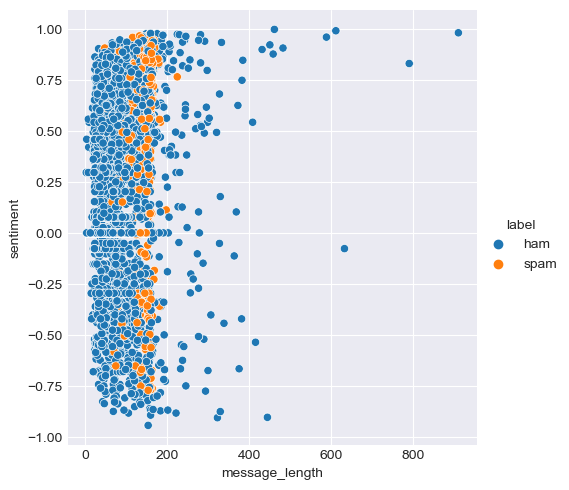

In [50]:
#plot message_length vs sentiment and hue by label

sns.relplot(data=df, x='message_length', y='sentiment', hue='label')

Plot univariate or bivariate distributions using <a href ="https://seaborn.pydata.org/generated/seaborn.kdeplot.html">kernel density estimation</a>.
  

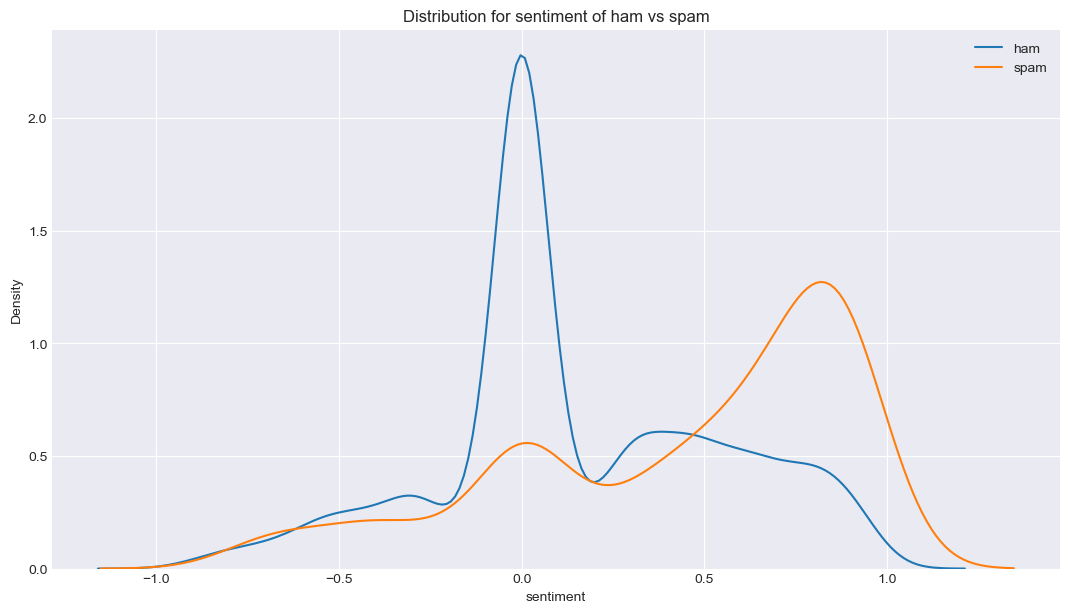

In [51]:
# is the distribution for sentiment different for ham vs spam

sns.kdeplot(df[df.label=='ham'].sentiment, label='ham')
sns.kdeplot(df[df.label=='spam'].sentiment, label='spam')

plt.legend(['ham', 'spam'])
plt.title("Distribution for sentiment of ham vs spam")
plt.show()

/var/folders/xv/ltdj6hd169j2bd0gclmjj3th0000gn/T/ipykernel_23515/2194897636.py:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(
/var/folders/xv/ltdj6hd169j2bd0gclmjj3th0000gn/T/ipykernel_23515/2194897636.py:7: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(


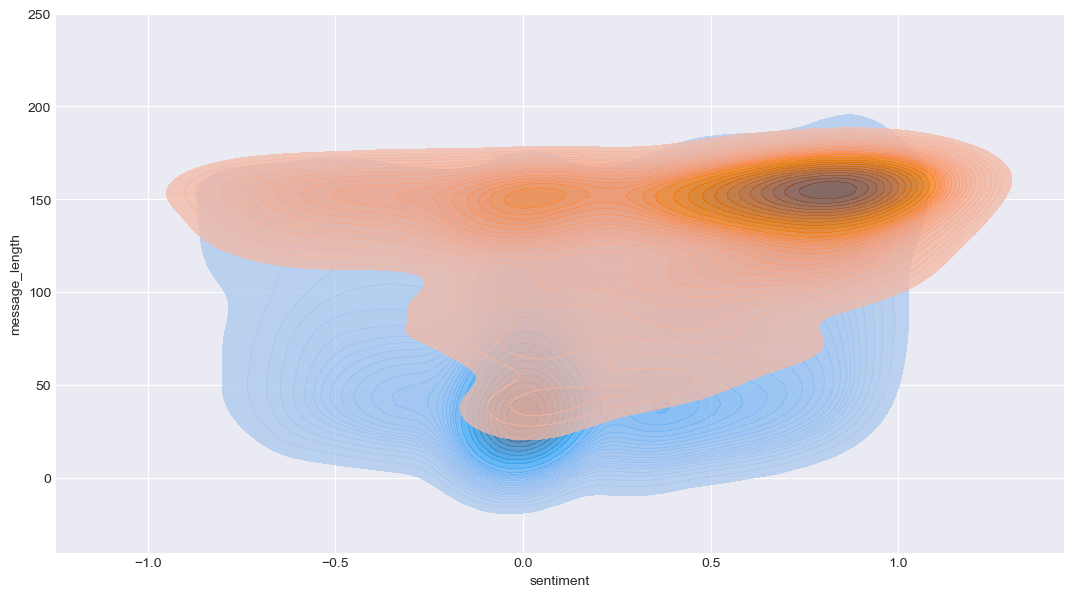

In [52]:
# Bivariate KDE plot for message_length vs sentiment score 
sns.kdeplot(
    x=df[df.label == 'ham'].sentiment,
    y=df[df.label == 'ham'].message_length, 
    levels = 30, shade = True, alpha=0.75);

sns.kdeplot(
    x=df[df.label == 'spam'].sentiment,
    y=df[df.label == 'spam'].message_length, 
    levels = 30, shade = True, alpha=0.75)

plt.ylim(top=250)
plt.show()

### Takeaways:
 - Spam messages seem to have roughly the same message length, where ham varies a lot.
 - Spam messages have a very positive sentiment
 - If we wanted to utilize these features for modeling, we would want to proceed forward with means testing to establish their viability

## More Resources

- [kaggle wikipedia movie plots](https://www.kaggle.com/jrobischon/wikipedia-movie-plots)
    - Suggestion: narrow to top n genres that aren't unknown
- [wikitable extractor](https://wikitable2csv.ggor.de/) (Try with, e.g. [helicopter prison escapes](https://en.wikipedia.org/wiki/List_of_helicopter_prison_escapes))
- [Textblob library](https://textblob.readthedocs.io/en/dev/)